Here we will use a neural network to predict diabetes using the Pima Diabetes Dataset. We will start by training a Logistic regression and Random Forest to get a performance baseline. Then we will use the Keras package to quickly build and train a neural network and compare the performance.

## UCI Pima Diabetes Dataset

* UCI ML Repositiory (http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

The UCI Pima Diabetes Dataset which has 8 numerical predictors and a binary outcome.

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_score, recall_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random
import seaborn as sns
from tqdm.notebook import tqdm


In [2]:
df = pd.read_csv('diabetes.csv')
print(df.shape)
df.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
((df['Glucose']==0)|(df['BloodPressure']==0)|(df['SkinThickness']==0)|(df['Insulin']==0)|(df['Age']==0)).sum()

375

We see there are 375 missing values (filled with zeros) among Glucose, BloodPressure, SkinThickness, Insulin, and Age. However, as our dataset has only 768 features, we will train our model without deleting features with missing values.

<Axes: xlabel='Outcome'>

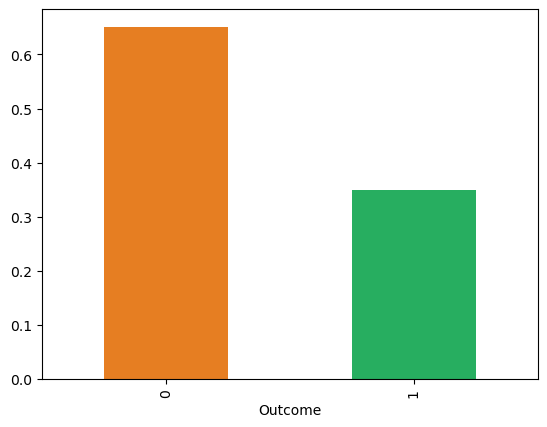

In [7]:
# # Get the row entries with the last col 'class'
df['Outcome'].value_counts(normalize=True)
df['Outcome'].value_counts(normalize=True).plot.bar(color=['#e67e22', '#27ae60'])

Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes.

First we will get a baseline performance using a Logistic Regression model.

In [8]:
# start the seed generator for random number
rs = 32

In [9]:
X = df.drop('Outcome',axis=1)
y = df['Outcome']

In [10]:
# First, let's split the training, validation, and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = rs)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = rs)

print(f"Training dataset shape, X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation dataset shape, X_val: {X_val.shape}, y_train: {y_val.shape}")
print(f"Testing dataset shape, X_test: {X_test.shape}, y_test: {y_test.shape}")

Training dataset shape, X_train: (614, 8), y_train: (614,)
Validation dataset shape, X_val: (123, 8), y_train: (123,)
Testing dataset shape, X_test: (154, 8), y_test: (154,)


In [11]:
split_index = [0 if x in X_val.index else -1 for x in X_train.index]

In [12]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()
# Scaling the raw input features
X_train = scaler.fit_transform(X_train)
X_tr = scaler.fit_transform(X_tr)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)
# also convert y to array
y_train = np.array(y_train)
y_tr    = np.array(y_tr)
y_val   = np.array(y_val)
y_test  = np.array(y_test)


In [13]:
# Define a logistic regression model with above arguments
lr_model = LogisticRegression(random_state=rs, max_iter = 100)
lr_model.fit(X_train, y_train)
lr_score = lr_model.score(X_test, y_test)
print(f"The test score for the logistic regression is {round(lr_score, 2)}")

The test score for the logistic regression is 0.78


Now that we improved on our 65% estimative with Logistic regression, let's see how we can improve it further with RandomForest.

In [14]:
cv_params = {'max_depth':[2,4,8,None],
             'min_samples_leaf':[1,2,4],
             'min_samples_split':[2,4],
             'max_features':[2,4,6],
             'n_estimators':[50,100,200]}

rf = RandomForestClassifier(random_state = rs)

scoring = {'accuracy','precision','recall','f1'}

custom_split = PredefinedSplit(split_index)

rf_cv = RandomizedSearchCV(rf,cv_params,cv=custom_split,refit='f1')

rf_cv.fit(X_train,y_train)

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([ 0,  0, ...,  0, -1])),
                   estimator=RandomForestClassifier(random_state=32),
                   param_distributions={'max_depth': [2, 4, 8, None],
                                        'max_features': [2, 4, 6],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4],
                                        'n_estimators': [50, 100, 200]},
                   refit='f1')

In [15]:
print('RandomForrest best params',rf_cv.best_params_)
print(f"RandomForrest training score {round(rf_cv.best_score_, 2)}")

rf_score = rf_cv.score(X_test, y_test)
print(f"The test score for the RandomForest is {round(rf_score, 2)}")

RandomForrest best params {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 2, 'max_depth': 8}
RandomForrest training score 0.74
The test score for the RandomForest is 0.78


RandomForrest performed just slightly better than Logistic Regression.
In the next step, we try to build a NN with Keras.

In [16]:
model_nn = Sequential()

# add layers
model_nn.add(Dense(8, activation='sigmoid',
                   input_shape = (8,) )) # X_train.shape[1:] = (17,)
model_nn.add(Dropout(0.2,seed=rs))
model_nn.add(Dense(6, activation='sigmoid'))
model_nn.add(Dropout(0.2,seed=rs))
model_nn.add(Dense(6, activation='sigmoid'))
model_nn.add(Dropout(0.2,seed=rs))
model_nn.add(Dense(1, activation='sigmoid')) #
optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model_nn.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])

model_nn.summary()

/Users/brncat/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │            54 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175 (700.00 B)

 Trainable params: 175 (700.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
run_hist = model_nn.fit(X_tr, y_tr, epochs=500, batch_size=8, validation_data=(X_val,y_val),shuffle=True)

Epoch 1/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6111 - loss: 0.7161 - val_accuracy: 0.6667 - val_loss: 0.6392
Epoch 2/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - accuracy: 0.6219 - loss: 0.6915 - val_accuracy: 0.6667 - val_loss: 0.6368
Epoch 3/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 0.6491 - loss: 0.6762 - val_accuracy: 0.6667 - val_loss: 0.6364
Epoch 4/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - accuracy: 0.6517 - loss: 0.6389 - val_accuracy: 0.6667 - val_loss: 0.6367
Epoch 5/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - accuracy: 0.6396 - loss: 0.6496 - val_accuracy: 0.6667 - val_loss: 0.6368
Epoch 6/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - accuracy: 0.5802 - loss: 0.6907 - val_accuracy: 0.6667 - val_loss: 0.6371
Epoch 7/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - accuracy: 0.6643 - loss: 0.6587 - val_accuracy: 0.6667 - val_loss: 0.6372
Epoch 8/500
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - accuracy: 0.6020 - loss: 0.6582 - val_accura

In [18]:
evaluate = model_nn.evaluate(X_test,y_test,batch_size=32)

print('Test loss: ', evaluate[0])
print('Test accuracy: ', evaluate[1])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - accuracy: 0.7662 - loss: 0.4669
Test loss:  0.4512855112552643
Test accuracy:  0.8051947951316833


In [19]:
run_hist.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

Text(0.5, 1.0, 'Accuracy over iterations')

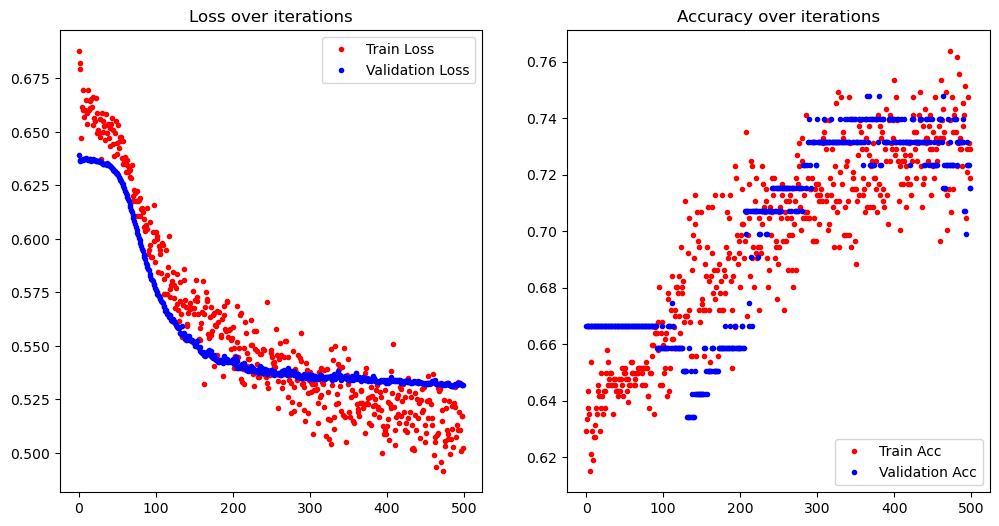

In [20]:
n = len(run_hist.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (run_hist.history["loss"]),'r.', label="Train Loss")
ax.plot(range(n), (run_hist.history["val_loss"]),'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (run_hist.history["accuracy"]),'r.', label="Train Acc")
ax.plot(range(n), (run_hist.history["val_accuracy"]),'b.', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')

Remember, Deep learning neural networks are often considered "black box" models, meaning they are difficult to interpret and understand how they arrive at their predictions. If explainability is a main objective for a data science project, using simpler and more interpretable models like decision trees or linear regression is preferable. These models provide more transparent insights into how they make predictions, making them more suitable for cases where explainability is a priority.